In [1]:
import numpy as np
import matplotlib.pyplot as plt


class SingleLayer:
    def __init__(self, lr=.1, l1=0, l2=0):
        self.w = None
        self.b = None
        self.losses = []
        self.val_losses=[]
        self.w_history = []
        self.lr = lr
        self.l1 = l1
        self.l2 = l2
        
    def forward(self, x):
        return np.dot(x, self.w) + self.b
    
    def backward(self, x, err):
#         return x*err, err
        m = len(x)
        w_grad = np.dot(x.T, err) / m
        b_grad = np.sum(err) / m
        return w_grad, b_grad
    

    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        y = y.reshape(-1, 1)
        y_val = y_val.reshape(-1, 1)
        m=len(x)
        self.w = np.random.rand(x.shape[1],1)
        self.b = np.random.rand()
        self.w_history.append(self.w.copy())
        for i in range(epochs):
            z = self.forward(x)
            a = self.activation(z)
            err = -(y-a)
            w_grad, b_grad = self.backward(x, err)
            w_grad += (self.l1*np.sign(self.w) + self.l2*self.w) / m
            self.w -= self.lr * w_grad
            self.b -= self.lr * b_grad
            self.w_history.append(self.w.copy())
            a = np.clip(a, 1e-10, 1-1e-10)
            loss = np.sum(-(y*np.log(a) + (1-y)*np.log(1-a)))
            self.losses.append((loss + self.reg_loss()) / m)
            self.update_val_losses(x_val, y_val)
            
            
    def activation(self, z):
        return 1 / (1+np.exp(-z))
    
    def predict(self, x):
        return self.forward(x) > 0
    
    def score(self, x, y):
        return np.mean(self.predict(x)==y.reshape(-1, 1))
    
    def update_val_losses(self, x_val, y_val):
        if x_val is None or y_val is None:
            return
        z = self.forward(x_val)
        a = self.activation(z)
        a = np.clip(a, 1e-10, 1-1e-10)
        val_loss = np.sum(-(y_val*np.log(a) + (1-y_val)*np.log(1-a)))
        self.val_losses.append((val_loss + self.reg_loss())/ len(y_val))
        
    def reg_loss(self):
        return self.l1*np.sum(np.abs(self.w)) + self.l2/2*np.sum(self.w**2)

In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()
x = cancer.data
y = cancer.target
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify=y, 
                                                           test_size=.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all,
                                                 stratify=y_train_all, test_size=.2, random_state=42)

In [3]:
print(x_train.shape, x_val.shape)

(364, 30) (91, 30)


In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_val_scaled = scaler.transform(x_val)

In [5]:
single_layer = SingleLayer(l2=.01)
single_layer.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val, epochs=10000)

In [6]:
single_layer.score(x_val_scaled, y_val)

0.978021978021978

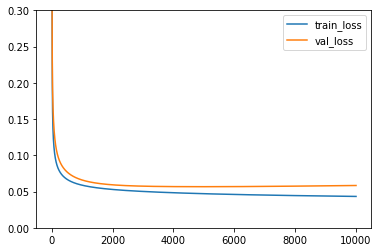

In [7]:
%matplotlib inline
plt.plot(single_layer.losses)
plt.plot(single_layer.val_losses)
plt.legend(['train_loss','val_loss'])
plt.ylim(0, .3)
plt.show()

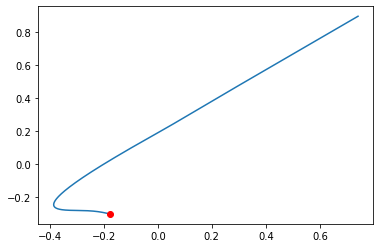

In [8]:
w2 = []; w3 = []
for w in single_layer.w_history:
    w2.append(w[2])
    w3.append(w[3])

plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1], 'ro')
plt.show()

In [12]:
class DualLayer(SingleLayer):
    def __init__(self, units=10, lr=.1, l1=0, l2=0):
        self.units =units
        self.w1 = None
        self.b1 = None
        self.w2 =None
        self.b2 = None
        self.a1 = None
        self.losses = []
        self.val_losses = []
        self.lr = lr
        self.l1 = l1
        self.l2 = l2
        
    def forward(self, x):
        z1 = np.dot(x, self.w1) + self.b1
        self.a1 = self.activation(z1)
        z2 = np.dot(self.a1, self.w2) + self.b2
        return z2
    
    def backward(self, x, err):
        m = len(x)
        w2_grad = np.dot(self.a1.T, err) / m
        b2_grad = np.sum(err) / m
        
        err_to_hidden = np.dot(err, self.w2.T) * self.a1 * (1- self.a1)
        
        w1_grad = np.dot(x.T, err_to_hidden) / m
        b1_grad = np.sum(err_to_hidden, axis=0) / m
        return w1_grad, b1_grad, w2_grad, b2_grad
    
    def init_weights(self, n_features):
        self.w1 = np.random.rand(n_features, self.units)
        self.b1 = np.random.rand(self.units)
        self.w2 = np.random.rand(self.units, 1)
        self.b2 = np.random.rand()
        
    def fit(self, x, y, epochs= 100, x_val= None, y_val=None):
        y = y.reshape(-1, 1)
        y_val = y_val.reshape(-1, 1)
        m = len(x)
        self.init_weights(x.shape[1])
        
        for i in range(epochs):
            a = self.training(x, y, m)
            a = np.clip(a, 1e-10, 1-1e-10)
            loss = np.sum(-(y*np.log(a) + (1-y)*np.log(1-a)))
            self.losses.append((loss + self.reg_loss())/m)
            self.update_val_losses(x_val, y_val)
            
    def training(self, x, y, m):
        z = self.forward(x)
        a = self.activation(z)
        err = -(y-a)
        
        w1_grad, b1_grad, w2_grad, b2_grad = self.backward(x, err)
        w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
        w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m
        
        self.w1 -= self.lr*w1_grad
        self.b1 -= self.lr*b1_grad
        
        self.w2 -= self.lr*w2_grad
        self.b2 -= self.lr*b2_grad
        
        return a
    
    def reg_loss(self):
        return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + \
            self.l2 / 2 * (np.sum(self.w1**2)  + np.sum(self.w2**2))
        

In [13]:
dual_layer = DualLayer(l2=.01)
dual_layer.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val, epochs=20000)

In [14]:
dual_layer.score(x_val_scaled, y_val)

0.978021978021978

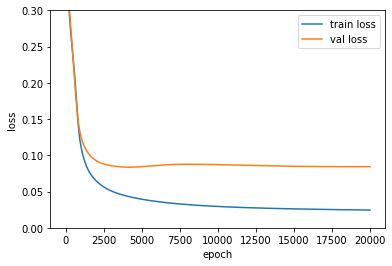

In [15]:
plt.ylim(0, .3)
plt.plot(dual_layer.losses)
plt.plot(dual_layer.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'])
plt.show()

In [16]:
class RandomInitNetwork(DualLayer):
    def init_weights(self, n_features):
        self.w1 = np.random.normal(0, 1, (n_features, self.units))
        self.b1 = np.zeros(self.units)
        self.w2 = np.random.normal(0, 1, (self.units, 1))
        self.b2 = 0

In [17]:
random_init_net = RandomInitNetwork(l2=.01)
random_init_net.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val, epochs=20000)

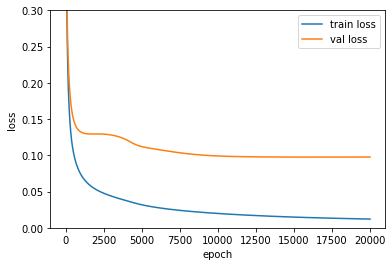

In [18]:
plt.ylim(0, .3)
plt.plot(random_init_net.losses)
plt.plot(random_init_net.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'])
plt.show()

In [39]:
class MinibatchNetwork(RandomInitNetwork):
    
    def __init__(self, units = 10, batch_size=32, lr = .1, l1=0, l2=0):
        super().__init__(units, lr, l1,l2)
        self.batch_size= batch_size
        
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        y = y.reshape(-1, 1)
        y_val = y_val.reshape(-1, 1)
        self.init_weights(x.shape[1])
        np.random.seed(42)
        
        for i in range(epochs):
            loss = 0
            
            for x_batch, y_batch in self.gen_batch(x,y):
                y_batch = y_batch.reshape(-1, 1)
                m = len(x_batch)
                a = self.training(x_batch, y_batch, m)
                a= np.clip(a, 1e-10, 1-1e-10)
                loss += np.sum(-(y_batch*np.log(a) + (1-y_batch)*np.log(1-a)))
            self.losses.append((loss + self.reg_loss()) / len(x))
            self.update_val_losses(x_val, y_val)
            
    def gen_batch(self, x, y):
        length = len(x)
        bins = length // self.batch_size
        if length % self.batch_size:
            bins += 1
        indexes = np.random.permutation(np.arange(len(x)))
        x = x[indexes]
        y = y[indexes]
        for i in range(bins):
            start = self.batch_size * i
            end = self.batch_size * (i + 1)
            yield x[start:end], y[start:end]

In [40]:
minibatch_net = MinibatchNetwork(l2=.01, batch_size=32)
minibatch_net.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val, epochs=500)
minibatch_net.score(x_val_scaled, y_val)

0.978021978021978

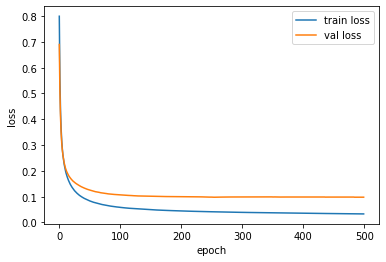

In [41]:
plt.plot(minibatch_net.losses)
plt.plot(minibatch_net.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'])
plt.show()

In [42]:
minibatch_net_128 = MinibatchNetwork(l2=.01, batch_size=128)
minibatch_net_128.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val, epochs=500)
minibatch_net_128.score(x_val_scaled, y_val)

0.978021978021978

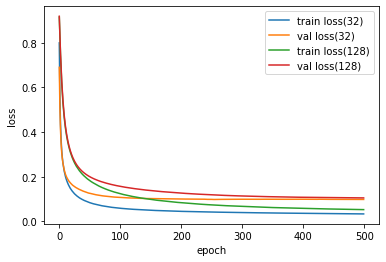

In [43]:
plt.plot(minibatch_net.losses)
plt.plot(minibatch_net.val_losses)
plt.plot(minibatch_net_128.losses)
plt.plot(minibatch_net_128.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss(32)', 'val loss(32)', 'train loss(128)', 'val loss(128)'])
plt.show()

In [44]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(10,), activation='logistic',
                   solver='sgd', alpha=.01, batch_size=32,
                   learning_rate_init=.1, max_iter=500)

In [45]:
mlp.fit(x_train_scaled, y_train)
mlp.score(x_val_scaled, y_val)

0.989010989010989

In [27]:
import numpy as np

class MulyiClassNetwork:
    
    def __init__(self, units=10, batch_size=32, learning_rate=.1, l1=0, l2=0):
        self.units = units
        self.batch_size = batch_size
        self.w1, self.w2, self.b1, self.b2, self.a1 = [None] * 5
        self.losses = []
        self.val_losses = []
        self.lr = learning_rate
        self.l1 = l1
        self.l2 = l2
        
    def forpass(self, x):
        z1 = np.dot(x, self.w1) + self.b1
        self.a1 = self.sigmoid(z1)
        z2 = np.dot(self.a1, self.w2) + self.b2
        return z2
    
    def backpass(self, x, err):
        m = len(x)
        w2_grad = np.dot(self.a1.T, err) / m
        b2_grad = np.sum(err) / m

        err_to_hidden = np.dot(err, self.w2.T) * self.a1 * (1 - self.a1)
        
        w1_grad = np.dot(x.T, err_to_hidden)/m
        b1_grad = np.sum(err_to_hidden, axis=0)/m
        
        return w1_grad, b1_grad, w2_grad, b2_grad
    
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def softmax(self, z):
        exp_z = np.exp(z)
        
        return exp_z / np.sum(exp_z, axis = 1).reshape(-1, 1)
    
    def init_weights(self, n_features, n_classes):
        self.w1 = np.random.normal(0, 1, (n_features, self.units))
        self.b1 = np.random.normal(0, 1, (self.units,))
        self.w2 = np.random.normal(0, 1, (self.units, n_classes))
        self.b2 = np.random.normal(0, 1, (n_classes,))
        
    def fit(self, x, y, epochs=100, x_val=None, y_val = None):
        np.random.seed(42)
        self.init_weights(x.shape[1], y.shape[1])
        for i in range(epochs):
            loss = 0
            print('.', end='')
            for x_batch, y_batch in self.gen_batch(x,y):
                a = self.training(x_batch, y_batch)
                a = np.clip(a, 1e-10, 1 - 1e-10)
                loss += np.sum(-y_batch*np.log(a))
            self.losses.append((loss + self.reg_loss())/ len(x))
            self.update_val_loss(x_val, y_val)
            
    def gen_batch(self, x, y):
        length = len(x)
        bins = length // self.batch_size
        if length % self.batch_size:
            bins += 1
        indexes = np.random.permutation(np.arange(len(x)))
        x = x[indexes]
        y = y[indexes]
        for i in range(bins):
            start = self.batch_size * i
            end = self.batch_size * (i+1)
            yield x[start: end], y[start: end]
            
    def training(self, x, y):
        m = len(x)
        z = self.forpass(x)
        a = self.softmax(z)
        
        err = -(y-a)
        w1_grad, b1_grad, w2_grad, b2_grad = self.backpass(x, err)
        
        w1_grad += (self.l1 * np.sign(self.w1) + self.l2*self.w1) / m
        w2_grad += (self.l1 * np.sign(self.w2) + self.l2*self.w2) / m
        
        self.w1 -= self.lr * w1_grad
        self.b1 -= self.lr * b1_grad
        
        self.w2 -= self.lr * w2_grad
        self.b2 -= self.lr * b2_grad
        
        return a
    
    def predict(self, x):
        return np.argmax(self.forpass(x), axis = 1)
    
    def score(self, x, y):
        return np.mean(self.predict(x) == np.argmax(y, axis = 1))
    
    def reg_loss(self):
        return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + \
                         self.l2 / 2 * (np.sum(self.w1**2) + np.sum(self.w2**2))
    
    def update_val_loss(self, x_val, y_val):
        z = self.forpass(x_val)
        a = self.softmax(z)
        a = np.clip(a, 1e-10, 1-1e-10)
        val_loss = np.sum(-y_val*np.log(a))
        self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))
        
        

In [2]:
import tensorflow as tf

/Users/h/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/Users/h/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/h/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/h/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/h/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility.

In [4]:
tf.__version__

'2.1.0'

In [5]:
(x_train_all, y_train_all), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [7]:
x_train_all.shape

(60000, 28, 28)

In [8]:
y_train_all.shape

(60000,)

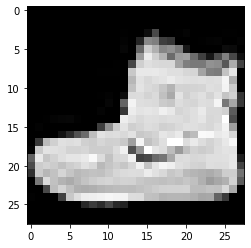

In [9]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.imshow(x_train_all[0], cmap='gray')
plt.show()

In [10]:
class_names = ['티셔츠/윗도리', '바지', '스웨터', '드레스', '코트',
               '샌들','셔츠', '스니커즈', '가방', '앵글부츠']

In [11]:
print(class_names[y_train_all[0]])

앵글부츠


In [12]:
np.bincount(y_train_all)

array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])

In [14]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify= y_train_all, test_size=.2, random_state=42)

In [15]:
np.bincount(y_train)

array([4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800])

In [16]:
x_train = x_train/255
x_val = x_val / 255

In [17]:
x_train = x_train.reshape(-1, 784)
x_val = x_val.reshape(-1, 784)

In [18]:
x_train.shape

(48000, 784)

In [19]:
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_val_encoded = tf.keras.utils.to_categorical(y_val)

In [21]:
print(y_train[0], y_train_encoded[0])

6 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [28]:
fc = MulyiClassNetwork(units=100, batch_size=256)
fc.fit(x_train, y_train_encoded, x_val=x_val, y_val=y_val_encoded, epochs=40)

........................................

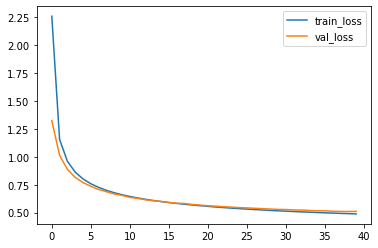

In [29]:
plt.plot(fc.losses)
plt.plot(fc.val_losses)
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [30]:
fc.score(x_val, y_val_encoded)

0.8185833333333333

In [43]:
#by keras
x_train_for_test_tf = np.random.rand(1000)
y_train_for_test_tf = 2 * x_train_for_test_tf + np.random.normal(0,1,[len(x_train_for_test_tf)])
print(x_train_for_test_tf.shape, y_train_for_test_tf.shape)
w = tf.Variable(tf.zeros(shape=(1)))
b = tf.Variable(tf.zeros(shape=(1)))

optimizer = tf.optimizers.SGD(lr = .01)
num_epochs = 10
for step in range(num_epochs):
    with tf.GradientTape() as tape:
        z_net = w * x_train_for_test_tf + b
        
        z_net = tf.reshape(z_net,[-1])

        sqr_errors = tf.square(y_train_for_test_tf - z_net)
        mean_cost = tf.reduce_mean(sqr_errors)
    grads = tape.gradient(mean_cost, [w,b])
    optimizer.apply_gradients(zip(grads, [w,b]))

(1000,) (1000,)


In [44]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer='sgd', loss='mse')
model.fit(x_train, y_train, epochs=10)

Train on 48000 samples
Epoch 1/10
48000/48000 [==============================] - 1s 24us/sample - loss: nan
Epoch 2/10
48000/48000 [==============================] - 1s 21us/sample - loss: nan
Epoch 3/10
48000/48000 [==============================] - 1s 23us/sample - loss: nan
Epoch 4/10
48000/48000 [==============================] - 1s 23us/sample - loss: nan
Epoch 5/10
48000/48000 [==============================] - 1s 21us/sample - loss: nan
Epoch 6/10
48000/48000 [==============================] - 1s 21us/sample - loss: nan
Epoch 7/10
48000/48000 [==============================] - 1s 21us/sample - loss: nan
Epoch 8/10
48000/48000 [==============================] - 1s 22us/sample - loss: nan
Epoch 9/10
48000/48000 [==============================] - 1s 24us/sample - loss: nan
Epoch 10/10
48000/48000 [==============================] - 1s 24us/sample - loss: nan


In [45]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
model = Sequential()

In [46]:
model.add(Dense(100, activation='sigmoid', input_shape=(784,)))
model.add(Dense(10, activation='softmax'))

In [47]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

In [48]:
history = model.fit(x_train, y_train_encoded, epochs=40, validation_data=(x_val,y_val_encoded))

Train on 48000 samples, validate on 12000 samples
Epoch 1/40
48000/48000 [==============================] - 2s 40us/sample - loss: 1.3666 - accuracy: 0.6422 - val_loss: 0.9601 - val_accuracy: 0.7285
Epoch 2/40
48000/48000 [==============================] - 2s 36us/sample - loss: 0.8416 - accuracy: 0.7431 - val_loss: 0.7495 - val_accuracy: 0.7602
Epoch 3/40
48000/48000 [==============================] - 2s 36us/sample - loss: 0.7103 - accuracy: 0.7666 - val_loss: 0.6620 - val_accuracy: 0.7810
Epoch 4/40
48000/48000 [==============================] - 2s 37us/sample - loss: 0.6443 - accuracy: 0.7816 - val_loss: 0.6100 - val_accuracy: 0.7946
Epoch 5/40
48000/48000 [==============================] - 2s 36us/sample - loss: 0.6022 - accuracy: 0.7943 - val_loss: 0.5745 - val_accuracy: 0.8040
Epoch 6/40
48000/48000 [==============================] - 2s 37us/sample - loss: 0.5719 - accuracy: 0.8042 - val_loss: 0.5490 - val_accuracy: 0.8108
Epoch 7/40
48000/48000 [==============================] 

In [49]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


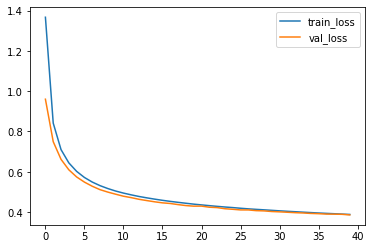

In [50]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train_loss', 'val_loss'])
plt.show()

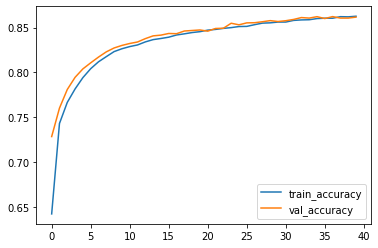

In [51]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [52]:
model.evaluate(x_val, y_val_encoded)

12000/12000 [==============================] - 0s 23us/sample - loss: 0.3863 - accuracy: 0.8618


[0.3862546974817912, 0.86175]